## Inspect and Clean Data:
### Malwai household data 2010


### Functions adopted from DataDriven Jupyter Notebook: <br> 00.0-data-preparation.ipynb
### Source: <br> The World Bank data preparation notebook available @ GitHub: <br> https://github.com/worldbank/ML-classification-algorithms-poverty/tree/master/notebooks


In [1]:
%matplotlib inline

import os
import sys
import json

from pathlib import Path
from pathlib import PureWindowsPath

import numpy as np
import pandas as pd
from pandas.io.stata import StataReader

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from data import load_data
from features import process_features

In [2]:
def load_stata_file(filepath, 
                    index_cols, 
                    update_education=False, 
                    drop_minornans=False, 
                    drop_unlabeled=False):
    """ Load data and metadata from Stata file"""
    data = pd.read_stata(filepath, convert_categoricals=False).set_index(index_cols)

    with StataReader(filepath) as reader:
        reader.value_labels()
            
        mapping = {col: reader.value_label_dict[t] for col, t in 
                   zip(reader.varlist, reader.lbllist)
                   if t in reader.value_label_dict}
        
        # manually update some specific columns
        # in the Malawi dataset
        if update_education and 'ind_educ09' in mapping:
            mapping['ind_educ09'][13] = "Primary - " + mapping['ind_educ09'][13]
            mapping['ind_educ09'][14] = "Primary - " + mapping['ind_educ09'][14]
            
            mapping['ind_educ09'][23] = "Secondary - " + mapping['ind_educ09'][23]
            mapping['ind_educ09'][24] = "Secondary - " + mapping['ind_educ09'][24]
        
        data.replace(mapping, inplace=True)
        
        # convert the categorical variables into
        # the category type
        for c in data.columns:
            if c in mapping:
                data[c] = data[c].astype('category')
                        
        # drop records with only a few nans
        if drop_minornans: 
            nan_counts = (data.applymap(pd.isnull)
                          .sum(axis=0)
                          .sort_values(ascending=False))
            nan_cols = nan_counts[(nan_counts > 0) & (nan_counts < 10)].index.values
            data = data.dropna(subset=nan_cols)
        # drop unlabeled categorical values
        def find_unlabeled(x):
            if x.name in mapping.keys():
                return [val if (val in mapping[x.name].values() or pd.isnull(val)) 
                        else 'UNLABELED' for val in x]
            else:
                return x
            
        data = data.apply(find_unlabeled)
        data = data[~data.applymap(lambda x: x == "UNLABELED").any(axis=1)]
        
        # read the actual questions that were asked for reference
        questions = reader.variable_labels()
        
    return data, questions

In [3]:
# Load Malawi household data

filepath = PureWindowsPath("C:\\Users\\micha\\Documents\\GitHub\\mkp_code\\Institute of Data Course\\Project 3\\data\\MWI_2010_IHS-III_v01_M_v01_A_ML_Stata\\MWI_2010_household.dta")


mwi_hhold, mwi_hhold_questions = load_stata_file(filepath, 
                                                 ['hid'], 
                                                 drop_minornans=True, 
                                                 drop_unlabeled=True)

s = 'Malawi household data has {:,} rows and {:,} columns'
print(s.format(mwi_hhold.shape[0], mwi_hhold.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(mwi_hhold.poor.value_counts(normalize=True).loc['Poor'], 
               mwi_hhold.poor.value_counts(normalize=True).loc['Non-poor']))
mwi_hhold.head()

Malawi household data has 12,244 rows and 346 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,wta_hh,wta_pop,der_hhsize,poor,hld_dwelloccu,hld_dwelltype,hld_walls,hld_roof,hld_floor,hld_rooms,...,com_weeklymrkt,com_postoffice,com_publicphone,com_distprimary,com_classrooms,com_schoolelec,com_medicines,com_clinic,com_distclinic,com_bank
hid,,,,,,,,,,,,,,,,,,,,,
101010160009,126.560097,759.360596,6,Poor,Owned,Traditional,Compacted earth,Grass,Smoothed mud,2,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160033,126.560097,506.240387,4,Poor,Owned,Traditional,Compacted earth,Grass,Smoothed mud,3,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160060,126.560097,1265.600952,10,Poor,Owned,Semi-Permanent,Burnt bricks,Grass,Smoothed mud,6,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160068,126.560097,1139.040894,9,Poor,Owned,Traditional,Mud,Grass,Smoothed mud,3,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160069,126.560097,126.560097,1,Non-poor,Owned,Traditional,Mud brick,Grass,Smoothed mud,2,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No


In [4]:
## Export dataframe values to csv for reference 
mwi_hhold.to_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_household.csv")

In [5]:
# Load Malawi individual data:

filepath = PureWindowsPath("C:\\Users\\micha\\Documents\\GitHub\\mkp_code\\Institute of Data Course\\Project 3\\data\\MWI_2010_IHS-III_v01_M_v01_A_ML_Stata\\MWI_2010_individual.dta")

 
mwi_indiv, mwi_indiv_questions = load_stata_file(filepath, 
                                                 ['hid', 'iid'], 
                                                 update_education=True)

s = 'Malawi individual data has {:,} rows and {:,} columns'
print(s.format(mwi_indiv.shape[0], mwi_indiv.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(mwi_indiv.poor.value_counts(normalize=True).loc['Poor'], 
               mwi_indiv.poor.value_counts(normalize=True).loc['Non-poor']))
mwi_indiv.head()

Malawi individual data has 56,211 rows and 42 columns
Percent poor: 52.4% 	Percent non-poor: 47.6%


ind_sex         ind_relation  ind_age ind_educfath  \
hid          iid                                                      
101010160009 1    Female                 Head       31         PSLC   
             2      Male         Wife/Husband       35         PSLC   
             3    Female  Child/Adopted child       10          NaN   
             4      Male  Child/Adopted child        6          NaN   
             5    Female  Child/Adopted child        3          NaN   

                 ind_educmoth ind_language  ind_religion  \
hid          iid                                           
101010160009 1           NONE       Lambya  Christianity   
             2           NONE          NaN  Christianity   
             3            NaN          NaN           NaN   
             4            NaN          NaN           NaN   
             5            NaN          NaN           NaN   

                                              ind_marital ind_readwrite  \
hid          iid                                                          
101010160009 1    Monogamous, married or non formal union           Yes   
             2    Monogamous, married or non formal union           Yes   
             3                                        NaN            No   
             4                                        NaN            No   
             5                                        NaN            No   

                 ind_rwchichewa  ...             ind_birthplace  \
hid          iid                 ...                              
101010160009 1              Yes  ...  Hospital/maternity clinic   
             2              Yes  ...                        NaN   
             3               No  ...                        NaN   
             4               No  ...                        NaN   
             5              NaN  ...                        NaN   

                 ind_birthattend ind_work1 ind_work2 ind_work3 ind_work4  \
hid          iid                                                           
101010160009 1             Nurse       0.0       Yes       NaN        No   
             2               NaN       0.0       Yes       NaN        No   
             3               NaN       0.0       Yes       NaN        No   
             4               NaN       0.0       Yes       NaN        No   
             5               NaN       NaN       NaN       NaN        No   

                 ind_work5 ind_work6      wta_hh  poor  
hid          iid                                        
101010160009 1         NaN        No  126.560097  Poor  
             2         NaN        No  126.560097  Poor  
             3         NaN        No  126.560097  Poor  
             4         NaN        No  126.560097  Poor  
             5         NaN       NaN  126.560097  Poor  

[5 rows x 42 columns]

In [6]:
## Export dataframe values to csv for reference 
mwi_indiv.to_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_individual.csv")

In [7]:
## Change the value in the poor variable:
# poor - True - 0
# non-poor - False - 1
# MKP
# mwi_hhold.poor = mwi_hhold.poor.replace({'Poor':0,'Non-poor':1})
# mwi_indiv.poor = mwi_indiv.poor.replace({'Poor':0,'Non-poor':1})
mwi_hhold.poor = (mwi_hhold.poor == 'Poor')

In [8]:
# Show some individual features that can be used to create features
pd.DataFrame.from_dict(mwi_indiv_questions, orient='index').head(10)

,0
hid,Unique HH Identifier
iid,Household Member ID Code
ind_sex,Sex
ind_relation,Relationship to Head
ind_age,How old is [NAME] (years)?
ind_educfath,What was the highest educational qualification...
ind_educmoth,What was the highest educational qualification...
ind_language,Which language do you speak at home?
ind_religion,"What religion, if any, does [NAME] practice"
ind_marital,What is [NAME]'s present marital status?


In [9]:
mwi_indiv_questions = pd.DataFrame.from_dict(mwi_indiv_questions, orient='index')

In [10]:
# Save the individual question dictionary to csv for further analysis
mwi_indiv_questions.to_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\mwi_indiv_questions.csv")

### Build derived features from individual data :
* Number of children (age 10 and under) in household 
* Number of males in household (over 10 years old)
* Number of females in household (over 10 years old)
* Number of literate household members (over 10 years old)
* Number of household members employed in the past 12 months

In [11]:
""" General function to add derived feature """
def add_derived_feature(df, 
                        feature_name, 
                        values, 
                        questions_dict, 
                        question=None):
                        
    '''Add a derived feature to the household dataframe and update questions'''
    df['der_' + feature_name] = values
    questions_dict['der_' + feature_name] = question
    return

In [12]:
# MWI - Number of children (10 and under) in household
values = (mwi_indiv.ind_age <= 10).sum(level=0).astype(int)
question = 'Number of children in household age 10 and under'
add_derived_feature(mwi_hhold, 
                    'nchild10under', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)

In [13]:
# MWI - Number of males and females in household over age 10
values = ((mwi_indiv.ind_sex == 'Male') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of males in household over age 10'
add_derived_feature(mwi_hhold, 'nmalesover10', values, mwi_hhold_questions, question=question)
values = ((mwi_indiv.ind_sex == 'Female') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of females in household over age 10'
add_derived_feature(mwi_hhold, 
                    'nfemalesover10', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)

In [14]:
# MWI - Number of household members who can read and write in any language
values = (mwi_indiv.ind_readwrite == 'Yes').sum(level=0).astype(int)
question = 'Number of household members who can read and write'
add_derived_feature(mwi_hhold, 
                    'nliterate', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)

In [15]:
# MWI - Number of household members employed in past 12 months
values = (mwi_indiv.ind_work4 == 'Yes').sum(level=0).astype(int)
question = 'Number of household members employed in past 12 months (over age 10)'
add_derived_feature(mwi_hhold, 
                    'nemployedpastyear', 
                    values,
                    mwi_hhold_questions,
                    question=question)

In [16]:
# create dummy variables for categoricals
mwi_hhold = pd.get_dummies(mwi_hhold, drop_first=True, dummy_na=True, prefix_sep='__')

# print the results - as a checkpoint
print("Malawi household shape with dummy variables added", mwi_hhold.shape)

Malawi household shape with dummy variables added (12244, 816)


In [17]:
# remove columns with only one unique value -
# (all nan dummies from columns with no missing values)
mwi_hhold = mwi_hhold.loc[:, mwi_hhold.nunique(axis=0) > 1]

# print the results - as a checkpoint
print("Malawi household shape with constant columns dropped", mwi_hhold.shape)


Malawi household shape with constant columns dropped (12244, 527)


In [18]:
# remove duplicate columns - these end up being all from nan or Not Applicable dummies 
process_features.drop_duplicate_columns(mwi_hhold, ignore=['wta_hh', 'wta_pop'], inplace=True)

# print the results - as a checkpoint
print("Malawi household shape with duplicate columns dropped", mwi_hhold.shape)


Malawi household shape with duplicate columns dropped (12244, 487)


In [19]:
## Export dataframe values to csv for reference - use in the next stage
mwi_hhold.to_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_household.csv")

### Malawi Exploration

First, let's look at the Malawi data. We may want to see if there are any distinct relationships between features and the target variable. We can inspect this by plotting the distribution of features out against the target, or by calculating the correlation between each feature and the target.

In the Malawi data, we only have a few features that are not categoricals. In fact, all of the non-categorical features in this case are small integer responses, such as the number of individuals in the household. We could actually consider these categoricals as well or bin them into categorical ranges, but for illustrative purposes we will keep them as numeric features.

In [20]:
def plot_numeric_hist(df, 
                      col, 
                      x_label, 
                      y_label='Percentage of Households', 
                      target='poor', 
                      integer_ticks=True, 
                      ax=None):
    if ax is None:
        ax = plt.gca()
    
    df.groupby(df[target])[col].plot.hist(bins=np.arange(0, df[col].max()) - 1, 
                                          alpha=0.5, 
                                          normed=True, 
                                          ax=ax)

    ax.set_xlim([0,df[col].max()])
    if integer_ticks:
        ax.set_xticks(np.arange(0,df[col].max()) + 0.5)
        ax.set_xticklabels(np.arange(0,df[col].max()+1, dtype=int))
        ax.xaxis.grid(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(title='poor')

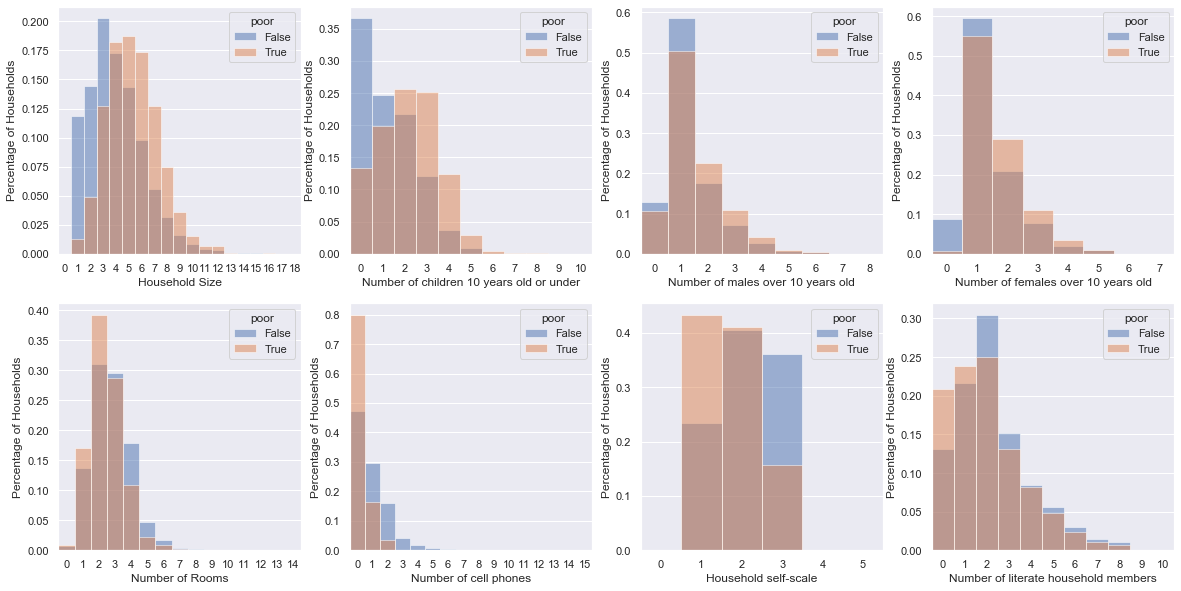

In [21]:
# Compare poor vs non-poor numeric features
#   We have 8 numeric features, so we make a 2x3 grid to plot them
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plot_numeric_hist(mwi_hhold, 
                  'der_hhsize', 
                  'Household Size', 
                  ax=axes[0][0])
plot_numeric_hist(mwi_hhold, 
                  'der_nchild10under', 
                  'Number of children 10 years old or under', 
                  ax=axes[0][1])
plot_numeric_hist(mwi_hhold, 
                  'der_nmalesover10', 
                  'Number of males over 10 years old', 
                  ax=axes[0][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nfemalesover10', 
                  'Number of females over 10 years old', 
                  ax=axes[0][3])
plot_numeric_hist(mwi_hhold, 
                  'hld_rooms', 
                  'Number of Rooms', 
                  ax=axes[1][0])
plot_numeric_hist(mwi_hhold, 
                  'hld_nbcellpho', 
                  'Number of cell phones', 
                  ax=axes[1][1])
plot_numeric_hist(mwi_hhold, 
                  'hld_selfscale', 
                  'Household self-scale', 
                  ax=axes[1][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nliterate', 
                  'Number of literate household members', 
                  ax=axes[1][3])

plt.show()

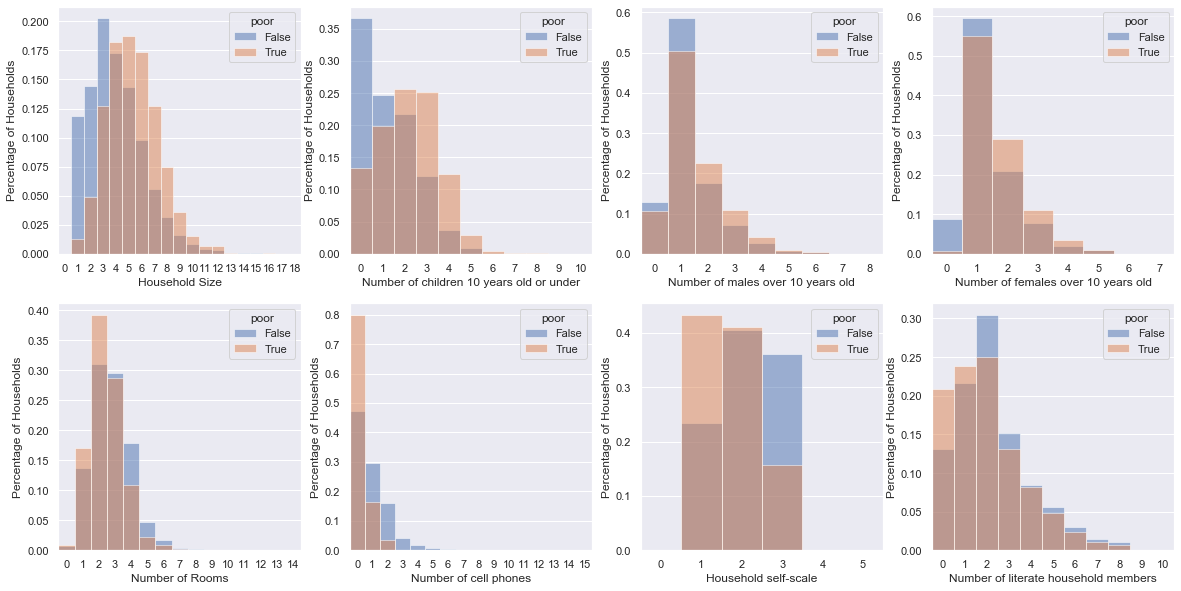

In [22]:
# Compare poor vs non-poor numeric features
#   We have 8 numeric features, so we make a 2x3 grid to plot them
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plot_numeric_hist(mwi_hhold, 
                  'der_hhsize', 
                  'Household Size', 
                  ax=axes[0][0])
plot_numeric_hist(mwi_hhold, 
                  'der_nchild10under', 
                  'Number of children 10 years old or under', 
                  ax=axes[0][1])
plot_numeric_hist(mwi_hhold, 
                  'der_nmalesover10', 
                  'Number of males over 10 years old', 
                  ax=axes[0][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nfemalesover10', 
                  'Number of females over 10 years old', 
                  ax=axes[0][3])
plot_numeric_hist(mwi_hhold, 
                  'hld_rooms', 
                  'Number of Rooms', 
                  ax=axes[1][0])
plot_numeric_hist(mwi_hhold, 
                  'hld_nbcellpho', 
                  'Number of cell phones', 
                  ax=axes[1][1])
plot_numeric_hist(mwi_hhold, 
                  'hld_selfscale', 
                  'Household self-scale', 
                  ax=axes[1][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nliterate', 
                  'Number of literate household members', 
                  ax=axes[1][3])

plt.show()

In [23]:
# Filter consumables and group by poor/non-poor
consumable_columns = [x for x in mwi_hhold.columns if x.startswith('cons_')]
consumables = (mwi_hhold.groupby('poor')[consumable_columns].sum().T)

consumables.columns = ['Non_poor', 'Poor']
consumables['total'] = consumables.sum(axis=1)
consumables['percent'] = consumables.total / mwi_hhold.shape[0]

# Match up the consumable names for readability
get_consumable_name = lambda x: mwi_hhold_questions[x.split('__')[0]]
consumables.index = consumables.index.map(get_consumable_name)

# Display the top 10 most common consumables
consumables.sort_values('percent', ascending=False).head(10)

,Non_poor,Poor,total,percent
Salt,6677.0,5471.0,12148.0,0.992159
"Milling fees, grain",6223.0,5238.0,11461.0,0.936050
Bar soap (body soap or clothes soap),6387.0,5027.0,11414.0,0.932212
Tomato,6105.0,4197.0,10302.0,0.841392
Matches,5810.0,4411.0,10221.0,0.834776
"Glycerine, Vaseline, skin creams",5888.0,4207.0,10095.0,0.824485
Dried fish,4798.0,3244.0,8042.0,0.656811
Cooking oil,5396.0,2571.0,7967.0,0.650686
Nkhwani,4316.0,3613.0,7929.0,0.647582
Sugar,5516.0,2393.0,7909.0,0.645949


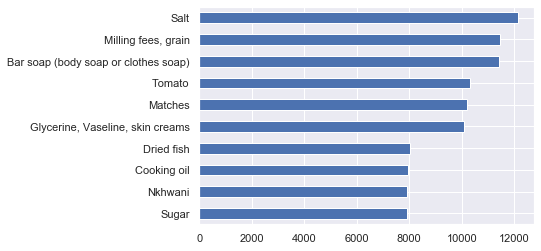

In [24]:
# Plot the top 10 most common consumables
colors = sns.color_palette('colorblind')
(consumables.total
            .sort_values(ascending=False)
            .head(10)
            .sort_values(ascending=True).plot.barh())

In [25]:
consumables['difference'] = (consumables.Non_poor - consumables.Poor) / consumables.total

# Display the top 20 most common consumables
display(consumables.sort_values('difference', ascending=False).head(20))

,Non_poor,Poor,total,percent,difference
Breakfast cereal,48.0,0.0,48.0,0.003920,1.000000
Night's lodging in rest house or hotel,62.0,0.0,62.0,0.005064,1.000000
Mortgage - regular payment to purchase house,5.0,0.0,5.0,0.000408,1.000000
Bottled water,74.0,0.0,74.0,0.006044,1.000000
Yoghurt,151.0,0.0,151.0,0.012333,1.000000
Butter,40.0,0.0,40.0,0.003267,1.000000
Tomato sauce (bottle),74.0,0.0,74.0,0.006044,1.000000
"Jam, jelly",32.0,0.0,32.0,0.002614,1.000000
"Cocoa, millo",131.0,0.0,131.0,0.010699,1.000000
Cheese,19.0,0.0,19.0,0.001552,1.000000


### Save the Final Processed Dataset as csv

In [26]:
## Export dataframe values to csv for reference - use in the next stage
mwi_indiv.to_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_individual.csv")

In [27]:
## Export dataframe values to csv for reference - use in the next stage
mwi_hhold.to_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_household.csv")